In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pandas import Series, DataFrame

C:\Users\hashi\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Upload the data 
opp_per100 = pd.read_table('opp_per100.txt', sep=',', header = 0)
opp_pergame = pd.read_table('opp_pergame.txt', sep=',', header = 0)
opp_shooting = pd.read_table('opp_shooting.txt', sep=',', header = 2)
team_misc = pd.read_table('team_misc.txt', sep=',', header = 1)
team_per100 = pd.read_table('team_per100.txt', sep=',', header = 0)
team_pergame = pd.read_table('team_pergame.txt', sep=',', header = 0)
team_shooting = pd.read_table('team_shooting.txt', sep=',', header = 2)

## Four-Factors 

To win basketball games, Dean Oliver identified the following statistics as being essential, he called these **"Four Factors of Basketball Success"**. The number in the parenthesis is the weight Dean Oliver gave each factor

* Shooting (40%) measured using `eFG%`
* Turnovers (25%) measured using `TOV%`
* Rebounding (20%) measured using `ORB%` and `DRB%`
* Freethrows (15%) measured using `FT%`

Let us see how accurate we are in predicting the number of wins each team had in the 2017-18 season using these factors and weights


## Methodology

I intend on using Weighted Least Sqaures regression, assiging the weights that Dean Oliver originally proposed. Let us explore the datasets now

### Plotting the Four Factors against Wins

Let us plot each of the four factors agains wins and inspect the relationship between them

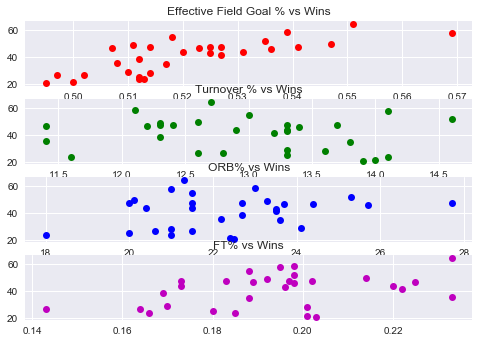

In [35]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex = False, sharey = True)

ax1.plot(team_misc['eFG%'], team_misc['W'], 'ro')
ax1.set_title('Effective Field Goal % vs Wins')

ax2.plot(team_misc['TOV%'], team_misc['W'], 'go')
ax2.set_title('Turnover % vs Wins')

ax3.plot(team_misc['ORB%'], team_misc['W'], 'bo')
ax3.set_title('ORB% vs Wins')

ax4.plot(team_misc['FT/FGA'], team_misc['W'], 'mo')
ax4.set_title('FT% vs Wins')

# Fine-tune figure; make subplots close to each other

plt.show()

## Results

For all four factors, there definitely seems to be linear enough of a relationship with wins to warrant trying to create a regression model

### Model

* Our independent variables will be 
    * eFG% 
    * ORB%
    * TOV%
    * FT%
* Our dependent variables will be
    * W (Wins) <br>


We will have to scale the data as the website I collected it from does not have the four factors in the same units

In [40]:
X_mat = team_misc[['eFG%', 'TOV%', 'ORB%', 'FT/FGA']]
y_mat = team_misc[['W']]

In [45]:
model = sm.OLS(y_mat, X_mat).fit()
predictions = model.predict(X_mat)

In [46]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     130.7
Date:                Fri, 08 Jun 2018   Prob (F-statistic):           8.12e-17
Time:                        09:16:59   Log-Likelihood:                -109.47
No. Observations:                  30   AIC:                             226.9
Df Residuals:                      26   BIC:                             232.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
eFG%         206.9963     71.721      2.886      0.0